In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

2025-07-28 11:10:07.495536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753701007.704988      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753701007.772683      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
TRAIN_FOLDER = '/kaggle/input/gtsrb-german-traffic-sign/train'
CSV_FILE = '/kaggle/input/gtsrb-german-traffic-sign/Train.csv'

num_of_categories = len(os.listdir(TRAIN_FOLDER))

folders = os.listdir(TRAIN_FOLDER)
images = []
classes = []
for folder in folders:
    images.append(len(os.listdir(TRAIN_FOLDER + '/' + folder)))
    classes.append(int(folder))

data = pd.DataFrame({'Class': classes, 'Image_Count': images})
data.head()

,Class,Image_Count
0,7,1440
1,17,1110
2,19,210
3,22,390
4,2,2250


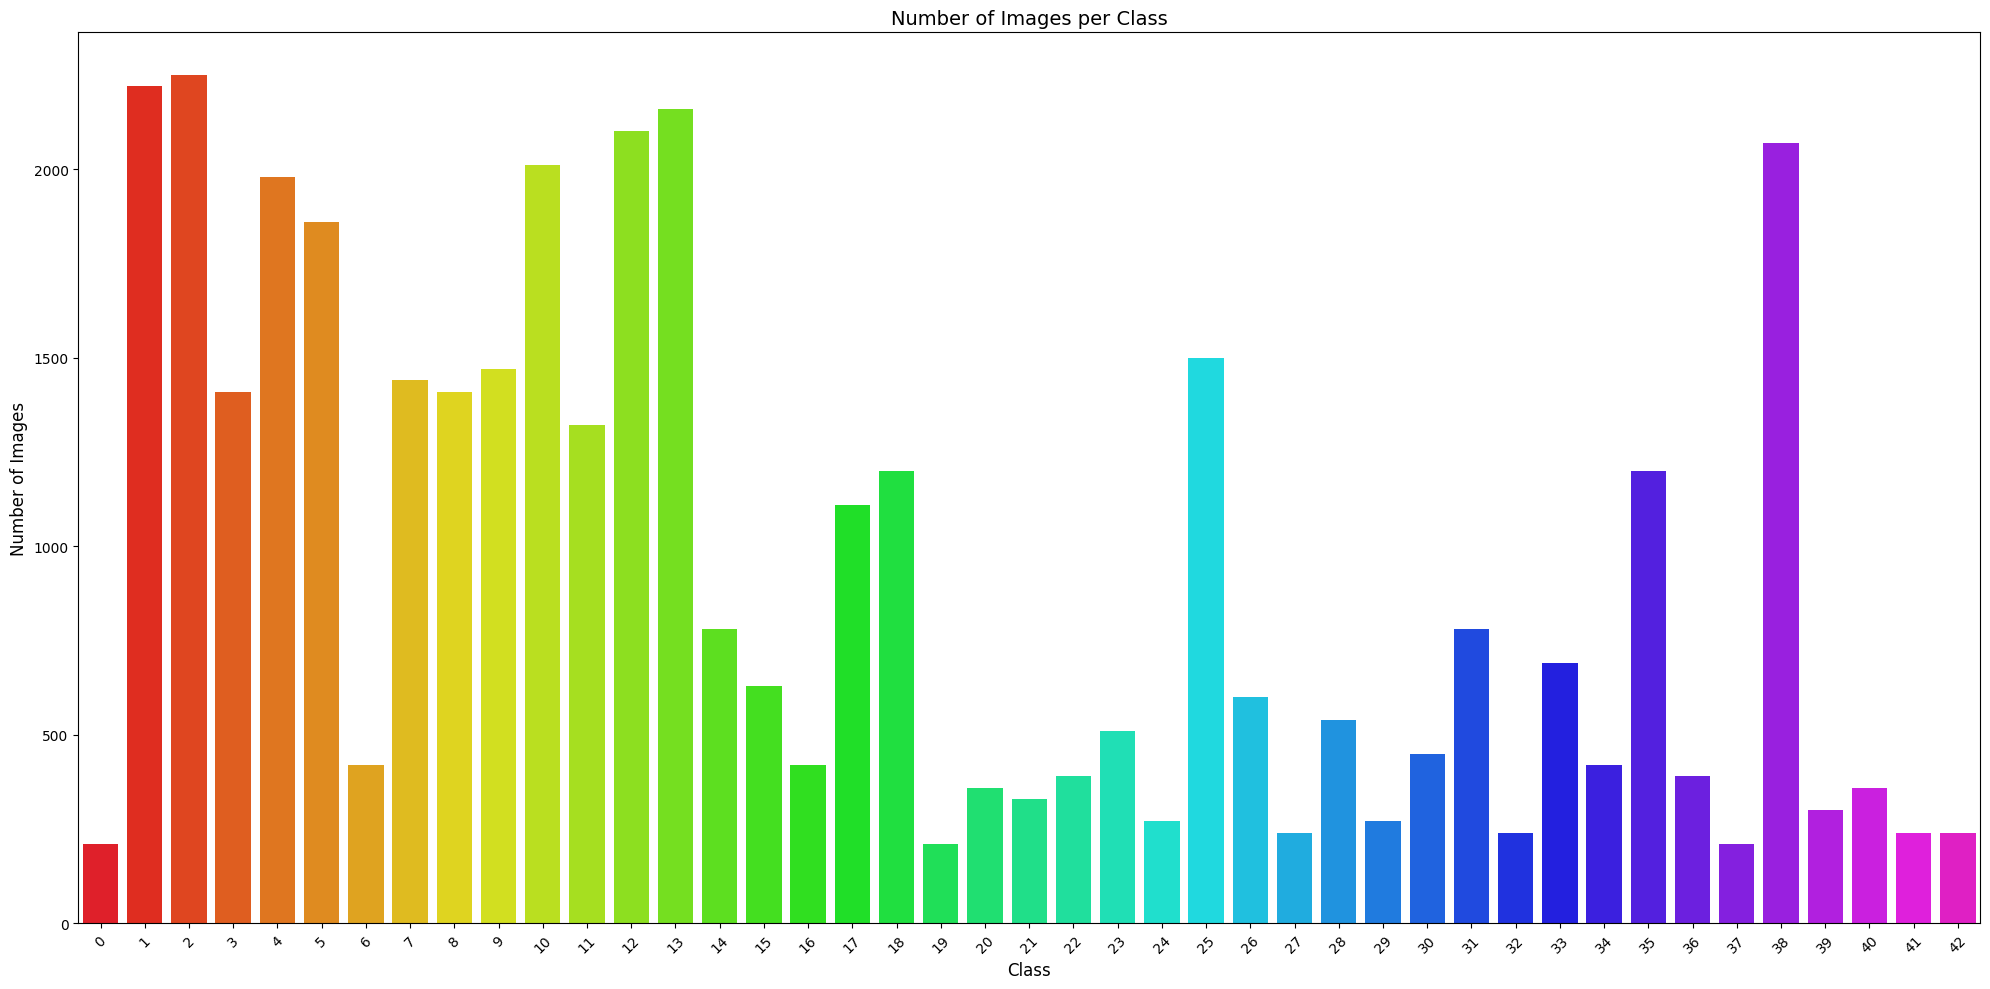

In [4]:
plt.figure(figsize=(20, 10))
sns.barplot(x='Class', y='Image_Count', data=data, palette='gist_rainbow')

plt.title('Number of Images per Class', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [5]:
IMG_HEIGHT, IMG_WIDTH = 32, 32
BATCH_SIZE = 64
df = pd.read_csv(CSV_FILE)
df

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


In [6]:
edit_pth = '/kaggle/input/gtsrb-german-traffic-sign'
df['Path'] = df['Path'].apply(lambda x: os.path.join(edit_pth, x))
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,/kaggle/input/gtsrb-german-traffic-sign/Train/...
1,28,27,5,6,23,22,20,/kaggle/input/gtsrb-german-traffic-sign/Train/...
2,29,26,6,5,24,21,20,/kaggle/input/gtsrb-german-traffic-sign/Train/...
3,28,27,5,6,23,22,20,/kaggle/input/gtsrb-german-traffic-sign/Train/...
4,28,26,5,5,23,21,20,/kaggle/input/gtsrb-german-traffic-sign/Train/...


In [7]:
df.Path[0]

'/kaggle/input/gtsrb-german-traffic-sign/Train/20/00020_00000_00000.png'

In [8]:
df['ClassId'] = df['ClassId'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  object
 7   Path     39209 non-null  object
dtypes: int64(6), object(2)
memory usage: 2.4+ MB


In [9]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClassId'], random_state=42)

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator with only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col='ClassId',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Path',
    y_col='ClassId',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 31367 validated image filenames belonging to 43 classes.
Found 7842 validated image filenames belonging to 43 classes.


In [11]:
num_classes = len(train_generator.class_indices)
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1753701115.198427      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 449,451 (1.71 MB)

 Trainable params: 448,555 (1.71 MB)

 Non-trainable params: 896 (3.50 KB)

In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, verbose=True, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    verbose=True,
    epochs=50,
    callbacks=early_stop
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1753701121.426113      96 service.cc:148] XLA service 0x7ae794004a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753701121.426722      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753701121.918659      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/491 ━━━━━━━━━━━━━━━━━━━━ 1:12:43 9s/step - accuracy: 0.0000e+00 - loss: 5.1795

I0000 00:00:1753701126.096685      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


491/491 ━━━━━━━━━━━━━━━━━━━━ 209s 408ms/step - accuracy: 0.0942 - loss: 3.6115 - val_accuracy: 0.1032 - val_loss: 3.3984
Epoch 2/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.2038 - loss: 2.9170 - val_accuracy: 0.2935 - val_loss: 2.5574
Epoch 3/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 58s 118ms/step - accuracy: 0.2845 - loss: 2.5481 - val_accuracy: 0.3843 - val_loss: 2.0768
Epoch 4/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 59s 120ms/step - accuracy: 0.3717 - loss: 2.1733 - val_accuracy: 0.4714 - val_loss: 1.7769
Epoch 5/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 61s 124ms/step - accuracy: 0.4302 - loss: 1.8794 - val_accuracy: 0.5273 - val_loss: 1.5080
Epoch 6/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 60s 122ms/step - accuracy: 0.4852 - loss: 1.6561 - val_accuracy: 0.5930 - val_loss: 1.2689
Epoch 7/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 57s 116ms/step - accuracy: 0.5369 - loss: 1.4716 - val_accuracy: 0.6394 - val_loss: 1.0929
Epoch 8/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 59s 120ms/step - accuracy: 0.5779 - loss: 1.3174 - va

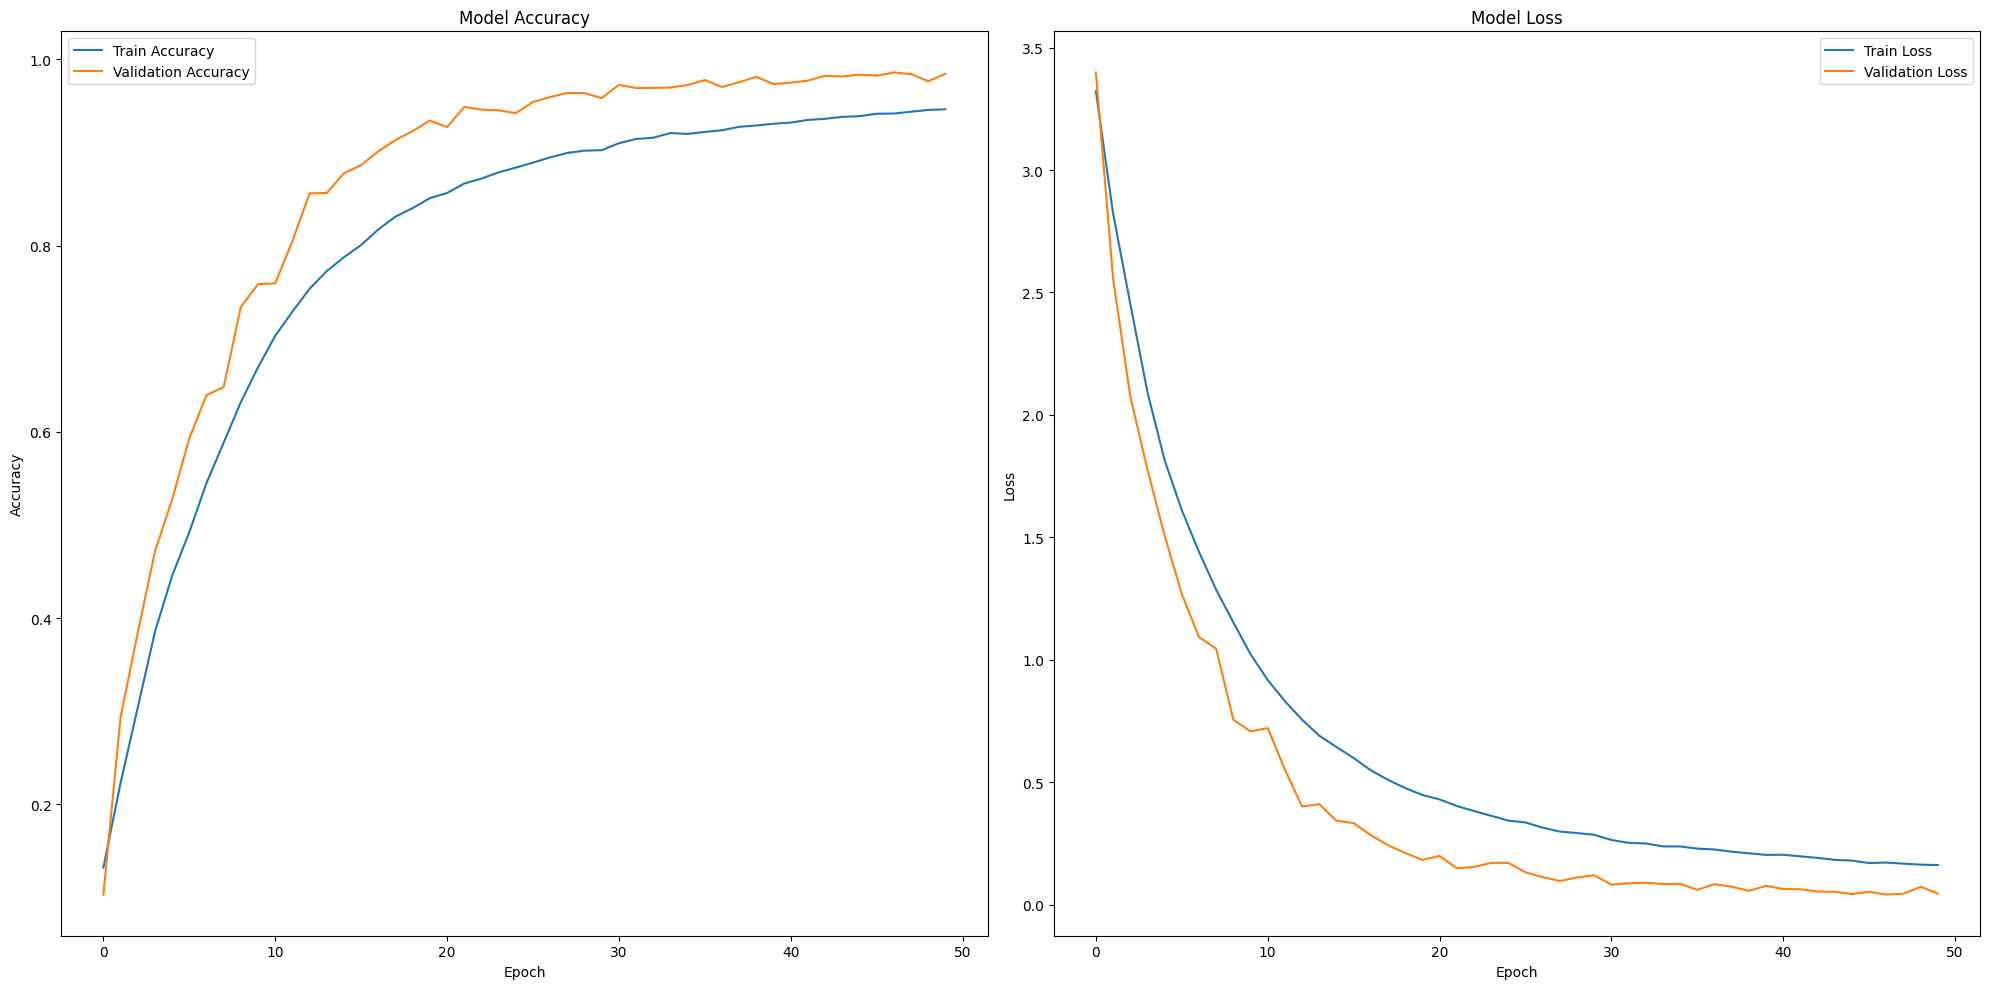

In [13]:
plt.figure(figsize=(20, 10))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
TEST_FOLDER = '/kaggle/input/gtsrb-german-traffic-sign'
TEST_CSV = '/kaggle/input/gtsrb-german-traffic-sign/Test.csv'
test_df = pd.read_csv(TEST_CSV)
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [15]:
test_df['Path'] = test_df['Path'].apply(lambda x: os.path.join(TEST_FOLDER, x))
test_df['ClassId'] = test_df['ClassId'].astype(str)
test_df

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,/kaggle/input/gtsrb-german-traffic-sign/Test/0...
1,42,45,5,5,36,40,1,/kaggle/input/gtsrb-german-traffic-sign/Test/0...
2,48,52,6,6,43,47,38,/kaggle/input/gtsrb-german-traffic-sign/Test/0...
3,27,29,5,5,22,24,33,/kaggle/input/gtsrb-german-traffic-sign/Test/0...
4,60,57,5,5,55,52,11,/kaggle/input/gtsrb-german-traffic-sign/Test/0...
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,/kaggle/input/gtsrb-german-traffic-sign/Test/1...
12626,50,51,6,5,45,46,33,/kaggle/input/gtsrb-german-traffic-sign/Test/1...
12627,29,29,6,6,24,24,6,/kaggle/input/gtsrb-german-traffic-sign/Test/1...
12628,48,49,5,6,43,44,7,/kaggle/input/gtsrb-german-traffic-sign/Test/1...


In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='ClassId',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 12630 validated image filenames belonging to 43 classes.


In [17]:
# Get predictions
test_generator.reset()
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}
images, labels = next(test_generator)
images = images[:20]
labels = labels[:20]
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


198/198 ━━━━━━━━━━━━━━━━━━━━ 58s 290ms/step


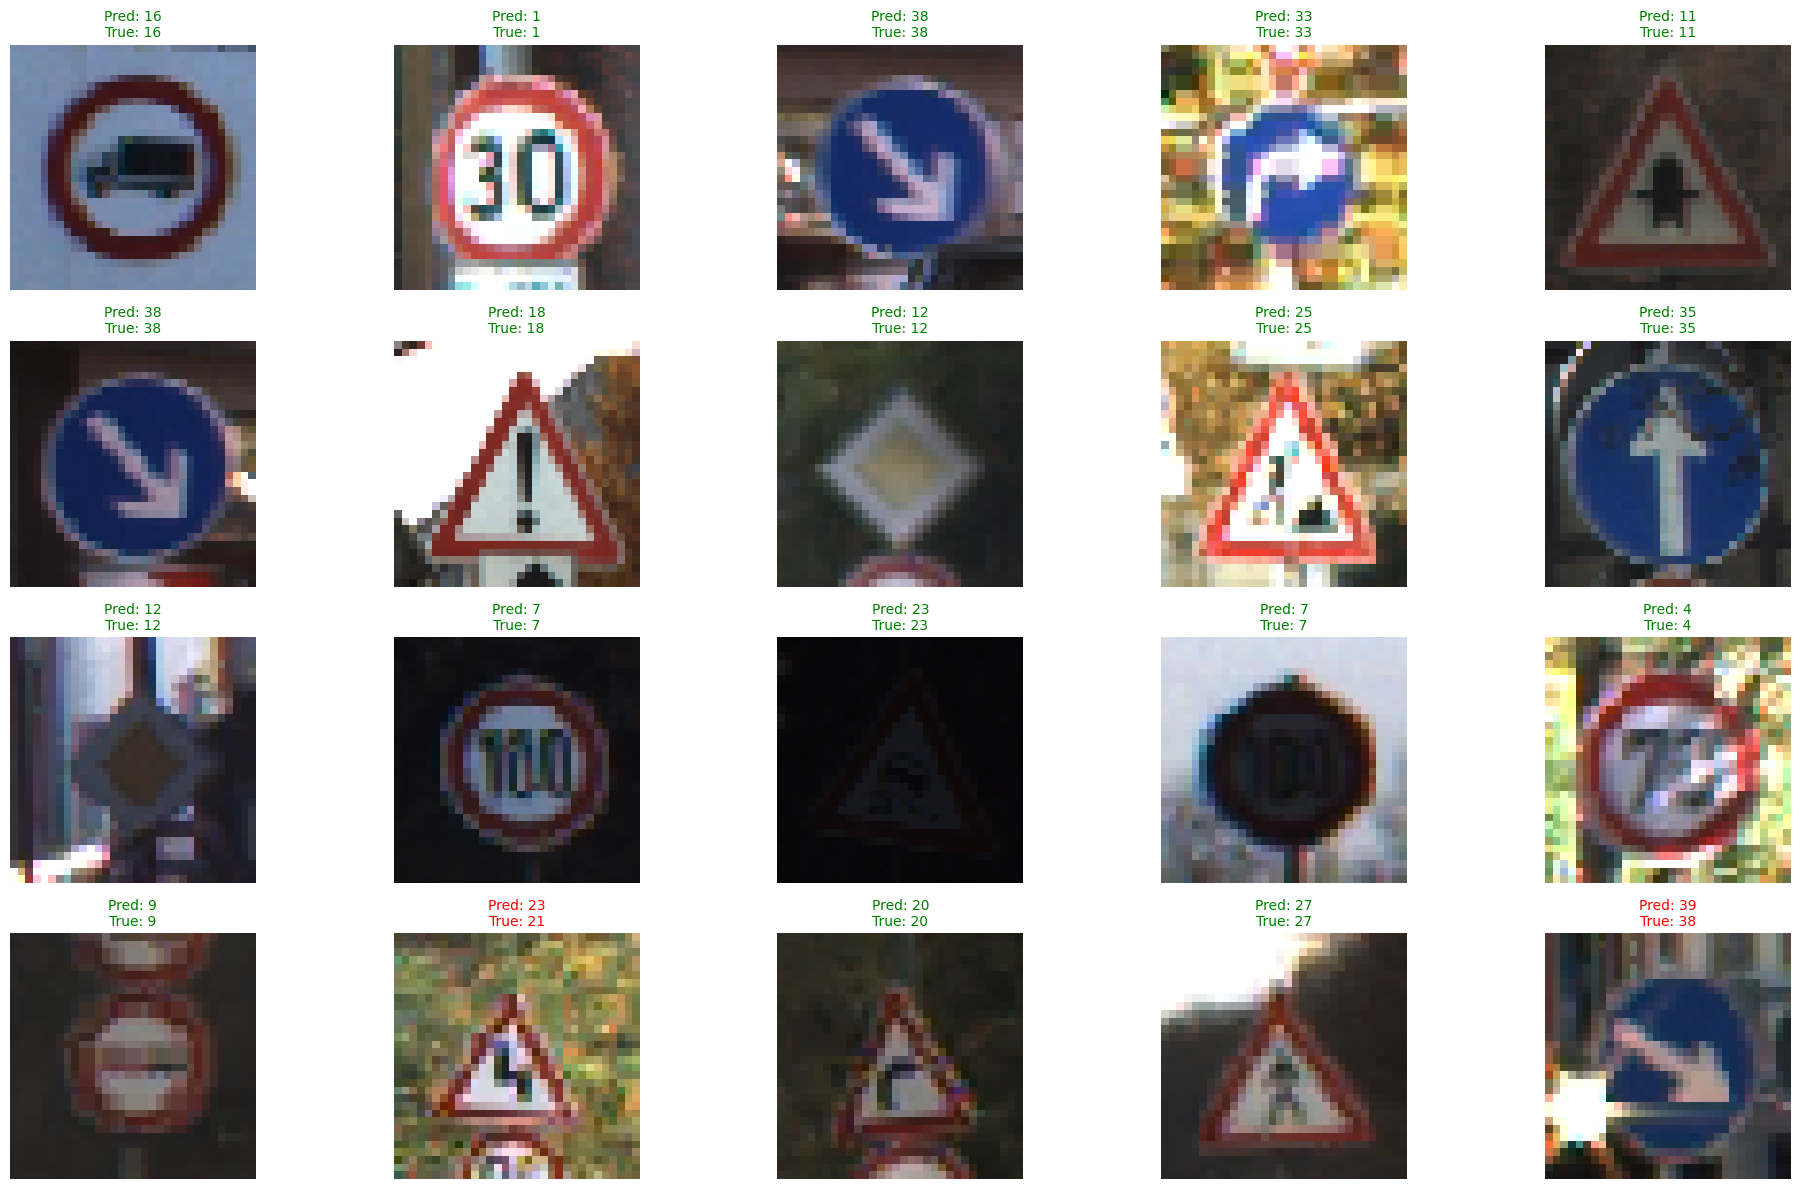

In [18]:
plt.figure(figsize=(20, 12))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    pred_label = class_names[predicted_classes[i]]
    true_label = class_names[true_classes[i]]
    title_color = 'green' if predicted_classes[i] == true_classes[i] else 'red'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=title_color, fontsize=10)
plt.tight_layout()
plt.show()

In [19]:
test_generator.reset()
test_loss, test_acc = model.evaluate(test_generator)
f"Validation Loss: {test_loss}, Validation Accuracy: {test_acc}"

198/198 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.9160 - loss: 0.3032


'Validation Loss: 0.30893829464912415, Validation Accuracy: 0.9141725897789001'

In [20]:
model.save("Traffic_Sign_Recognition.h5")